# Automated Discovery and Optimization of Quantum Error Correction Codes Using ML

### What is This Project About?
Quantum computers are highly powerful but fragile—errors occur due to noise and environmental disturbances. Quantum Error Correction (QEC) helps mitigate these errors, but designing efficient QEC codes is extremely difficult and currently relies on manual methods.

This project automates the discovery and optimization of QEC codes using Machine Learning (ML) and Reinforcement Learning (RL) techniques. Instead of relying on predefined error correction schemes, our approach lets an AI model "learn" the best QEC Surface Code Layout.

### Current Challenges in QEC
🔹 High Physical Qubit Overhead: Most QEC codes require 10-100x more qubits per logical qubit, making large-scale quantum computing impractical.

🔹 Decoding Complexity: Classical decoders (e.g., MWPM) require significant computational power, slowing down real-time error correction. 

🔹 Hardware-Specific Noise: QEC codes are often not optimized for specific quantum hardware (e.g., superconducting vs. trapped-ion), leading to inefficiencies.

🔹 QEC Execution Time: Errors accumulate faster than they can be corrected, reducing the effectiveness of QEC in real hardware.

### How This Project Improves QEC?
✅ Automates QEC Code Discovery: Uses ML & RL to generate new QEC codes optimized for real hardware.

✅ Reduces Qubit Overhead: Uses AI to find low-qubit-count QEC strategies.

✅ Customizes QEC for Hardware: Optimizes QEC codes specifically for different quantum architectures.

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pymatching  # For MWPM decoding
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit import transpile, assemble
import networkx as nx
import stim
from typing import List, Callable, Set

### SurfaceCodeLattice Class - Quantum Error Correction (QEC)

The `SurfaceCodeLattice` class represents a lattice structure for implementing quantum error correction (QEC) using surface codes. It provides methods for initializing qubit lattices, applying operations, simulating logical error rates, and decoding syndromes. This class is essential for exploring optimal lattice configurations that minimize logical error rates in QEC systems.

#### Core Functionality
- **Qubit Initialization & Lattice Setup**: The class initializes a lattice grid of qubits, either in a line or block pattern, and dynamically adds qubits as needed. The `split_plaquette` and `split_vertex` methods simulate lattice growth.
- **Logical Error Rate Simulation**: The `simulate_logical_error_rate` method runs a quantum circuit with noise to estimate the logical error rate (`P_L`), a crucial factor for assessing the effectiveness of a QEC system.
- **Syndrome Decoding**: The `decode_syndrome` method uses a matching algorithm to correct errors in the lattice, ensuring the system remains stable.
- **Visualization**: The `visualize_lattice` method graphically represents the lattice, helping users inspect the qubit arrangement and monitor lattice growth and error correction.

#### Importance for QEC Optimization
The `SurfaceCodeLattice` class is vital for testing different lattice configurations in search of the optimal layout. By minimizing the logical error rate and efficiently applying error correction, it helps identify the best surface code structure for quantum systems. This is essential for building reliable and scalable quantum computers that can handle noise and imperfections.


In [3]:
class SurfaceCodeLattice:
    def __init__(self, qubits: int = 3, lattice_size: int = 9, error_rate: float = 0.05):
        """
        Initializes the surface code lattice with the given number of qubits and lattice size.
        
        Args:
            qubits (int): The number of qubits in the surface code lattice. This defines the number of qubits initially placed in the lattice.
            lattice_size (int): The size of the lattice (assuming a square lattice for simplicity). It defines the dimensions of the grid.
            error_rate (float): The error rate for depolarizing errors (default is 0.05). This value simulates the level of noise affecting the qubits.
        
        Attributes:
            qubits (int): The number of qubits in the lattice. This field is dynamically updated as qubits are added.
            lattice_size (int): The size of the lattice, indicating the width and height of the square grid.
            error_rate (float): The depolarizing error rate that influences the error rate in the quantum operations.
            logical_error_rate (float): Stores the calculated logical error rate of the surface code, representing the probability of logical errors in the system.
            lattice (numpy.ndarray): A 2D array representing the surface code lattice, where qubits are placed as 1s, and empty spaces are 0s.
            positions (dict): A dictionary mapping each qubit index to its (x, y) position in the lattice for visualization and management.
            qubit_indices (dict): A dictionary mapping (x, y) coordinates to the qubit index, helping locate qubits in the lattice grid.
        """
        self.qubits = qubits
        self.lattice_size = lattice_size
        self.error_rate = error_rate
        self.logical_error_rate = 0.0
        self.lattice = self._initialize_lattice()
        self.positions = {}  # For visualization
        self.qubit_indices = {}  # Maps (x, y) to qubit index
        self._initialize_positions()

    def _initialize_lattice(self):
        """
            Initialize the surface code lattice as a square matrix of zeros.
        
            The lattice is represented by a 2D NumPy array where each element corresponds to a position in the lattice.
            Initially, all values are set to zero, indicating no qubits are placed.
        
            Returns:
                np.ndarray: A 2D array of zeros with dimensions (lattice_size, lattice_size).
        """
        return np.zeros((self.lattice_size, self.lattice_size), dtype=int)

    def _initialize_positions(self):
        """
        Initialize the positions of qubits in the lattice.
    
        The first `self.qubits` positions are initialized in a line or block pattern, 
        depending on the configuration. The positions dictionary tracks the location 
        of each qubit (by index), and the qubit_indices dictionary maps lattice 
        coordinates (x, y) to qubit indices.
    
        This method fills up the lattice with qubits and updates the positions and 
        qubit_indices dictionaries.
        """
        # Initialize the first `self.qubits` in a line or block pattern
        count = 0
        for x in range(self.lattice_size):
            for y in range(self.lattice_size):
                if count >= self.qubits:
                    return
                self.lattice[x, y] = 1
                self.positions[count] = (x, y)
                self.qubit_indices[(x, y)] = count
                count += 1

    def _add_qubit_at(self, x, y):
        """
        Add a qubit at the specified position (x, y) in the lattice.
    
        If the specified lattice position is empty (indicated by a value of 0), 
        a qubit is placed at that location, and the lattice, positions, and 
        qubit_indices dictionaries are updated accordingly. The number of qubits 
        is incremented.
    
        Args:
            x (int): The x-coordinate of the position where the qubit should be added.
            y (int): The y-coordinate of the position where the qubit should be added.
    
        Returns:
            bool: True if a qubit was successfully added, False if the position was already occupied.
        """
        if self.lattice[x, y] == 0:
            self.lattice[x, y] = 1
            qubit_id = self.qubits
            self.positions[qubit_id] = (x, y)
            self.qubit_indices[(x, y)] = qubit_id
            self.qubits += 1
            return True
        return False

    def split_plaquette(self):
        """
        Add a qubit at a random position within the lattice, simulating a plaquette split.
    
        A random position (x, y) within the lattice is selected, and a qubit is placed 
        at that position by calling the `_add_qubit_at` method.
    
        This method simulates the process of splitting a plaquette in the surface code, 
        thereby adding a new qubit to the lattice.
        """
        x, y = np.random.randint(0, self.lattice_size, size=2)
        self._add_qubit_at(x, y)

    def split_vertex(self):
        """
        Add a qubit at a random position within the lattice, simulating a vertex split.
    
        A random position (x, y) within the lattice is selected, and a qubit is placed 
        at that position by calling the `_add_qubit_at` method.
    
        This method simulates the process of splitting a vertex in the surface code, 
        thereby adding a new qubit to the lattice.
        """
        x, y = np.random.randint(0, self.lattice_size, size=2)
        self._add_qubit_at(x, y)

    def apply_move(self, move):
        """
        Apply a specified move to the lattice, either splitting a plaquette or vertex.
    
        Depending on the value of `move`, either a plaquette split or a vertex split is applied 
        to the lattice. This simulates the dynamic changes that can occur in a surface code 
        as part of its error correction strategy.
    
        Args:
            move (str): The type of move to apply, can be either "split_plaquette" or "split_vertex".
        """
            
        if move == "split_plaquette":
            self.split_plaquette()
        elif move == "split_vertex":
            self.split_vertex()
    
    def simulate_logical_error_rate(self, shots=1024):
        """
        Simulate the logical error rate based on the current surface code layout using Stim.
        Noise is added directly to the circuit using depolarizing gates.
        """
        circuit = stim.Circuit()

        #For each data qubit:
        #H: Apply a Hadamard gate to put the qubit into a superposition.
        #DEPOLARIZE1: Apply single-qubit depolarizing noise with strength self.error_rate.
        #This simulates bit/phase/random errors like in a real quantum system.
        for i in range(self.qubits):
            circuit.append("H", [i])
            circuit.append("DEPOLARIZE1", [i], self.error_rate)

        #For each adjacent pair of qubits:
        #CX: Apply a CNOT gate to simulate entanglement or stabilizer checks.
        #DEPOLARIZE2: Apply two-qubit depolarizing noise, which is more realistic for real CNOT gates.
        #This introduces entanglement and two-qubit noise — more dangerous than single-qubit errors.
        for i in range(self.qubits - 1):
            circuit.append("CX", [i, i + 1])
            circuit.append("DEPOLARIZE2", [i, i + 1], self.error_rate)

        #Measure the last qubit only (self.qubits - 1) in the Z basis.
        #This qubit is used as a proxy for a logical qubit.
        #The idea is: if a logical error occurred during noise+gates, this qubit's measurement will flip from 0 to 1.
        circuit.append("M", [self.qubits - 1])

        #Compile the circuit and sample it multiple times (shots=1024).
        #samples will be a NumPy array of shape (1024, 1) with either 0 or 1.
        #Each row is one simulation shot.
        #A 1 means that a logical error occurred in that shot (flipped outcome), while 0 means no error.
        sampler = circuit.compile_sampler()
        samples = sampler.sample(shots)

        #Count how many shots resulted in a logical error by summing up the 1s in the measurement result.
        #This gives the number of times the final logical qubit was corrupted by noise.
        logical_errors = np.sum(samples[:, 0])

        #P_L is the fraction of times a logical error occurred during the experiment.
        P_L = logical_errors / shots
        
        self.logical_error_rate = P_L
        return P_L

    def decode_syndrome(self, syndrome_results):
        """
        Decode the syndrome using PyMatching.
    
        Args:
            syndrome_results: A list or numpy array of syndrome bits (0 or 1),
                              typically one per stabilizer measurement.
        Returns:
            List of qubit indices to apply correction to.
        """
        num_syndromes = len(syndrome_results)
        num_qubits = self.qubits
        H = np.zeros((num_syndromes, num_qubits), dtype=int)

        for i in range(min(num_syndromes, num_qubits)):
            H[i, i] = 1

        matching = pymatching.Matching(H)
        syndrome_array = np.array(syndrome_results, dtype=np.uint8)
        correction = matching.decode(syndrome_array)

        error_correction = np.where(correction == 1)[0].tolist()
        return error_correction

    def visualize_lattice(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(self.lattice, cmap="Greys", origin="lower")

        for x in range(self.lattice_size):
            for y in range(self.lattice_size):
                if self.lattice[x, y] == 1:
                    ax.text(y, x, "Q", color="red", ha="center", va="center", fontsize=12, fontweight="bold")

        ax.set_xticks(np.arange(self.lattice_size))
        ax.set_yticks(np.arange(self.lattice_size))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(color='black', linestyle='-', linewidth=1)
        ax.set_title("Surface Code Lattice")
        plt.show()

### RLAgent Class for Reinforcement Learning in Quantum Error Correction Optimization

The `RLAgent` class implements a reinforcement learning agent that optimizes quantum error correction (QEC) by selecting actions that reduce the logical error rate in a surface code lattice. This class employs Q-learning, a model-free RL technique, to adaptively adjust lattice configurations and improve QEC performance over time.

The agent maintains a Q-table, which stores the expected future rewards for each action. With a learning rate (`alpha`) of 0.1 and a discount factor (`gamma`) of 0.95, the agent balances immediate rewards with long-term goals. It begins with a high exploration probability (`epsilon = 0.9`) to encourage discovery of various lattice configurations, which decays over time to favor exploitation of learned actions.

Action selection is based on the Q-table, where the agent either randomly explores or chooses the action with the highest Q-value. As the agent learns, it updates the Q-table using the reward received from its actions, refining its understanding of which actions lead to lower logical error rates. This process is crucial in optimizing surface code layouts to minimize errors in quantum circuits.

The agent’s ability to adjust its decisions based on previous experiences allows it to explore different lattice configurations, ultimately finding the most efficient setup with minimal qubits and logical error rates. By incorporating a reward function tied to the error rate, the agent ensures that its decisions lead to improved QEC performance.

This approach is vital in quantum computing, where optimizing resource usage and minimizing error rates is crucial. The `RLAgent` class not only helps in finding efficient surface code configurations but also provides insights into the learning process, tracking the Q-values over episodes for analysis. This makes it an essential tool for improving quantum error correction systems and enhancing the reliability of quantum computations.

State: [Number Of Qubits, Logical Error Rate]

Action Space: [split_plaquette, split_vertex]

In [182]:
class RLAgent:
    def __init__(self, num_actions):
        """
        Initialize the Q-learning agent.

        Args:
            num_actions (int): Total number of possible actions the agent can take.

        Attributes:
            q_table (np.ndarray): Q-values for each action, initialized to zero.
            alpha (float): Learning rate, determines how much new information overrides old.
            gamma (float): Discount factor, controls importance of future rewards.
            epsilon (float): Probability of choosing a random action (exploration rate).
            epsilon_decay (float): Factor by which epsilon decays after each episode.
            min_epsilon (float): Minimum value epsilon can decay to.
            num_actions (int): Number of available discrete actions.
            q_values_history (list): Stores snapshots of the Q-table after each update for visualization.
        """
        self.q_table = np.zeros(num_actions)
        self.alpha = 0.1  # Learning rate
        self.gamma = 0.95  # Discount factor
        self.epsilon = 0.9  # Initial exploration probability
        self.epsilon_decay = 0.995  # Decay rate for epsilon
        self.min_epsilon = 0.1  # Minimum epsilon
        self.num_actions = num_actions
        self.q_values_history = []  # To track Q-values over time

    def choose_action(self):
        """
        Select an action using an ε-greedy strategy.

        Returns:
            int: The index of the chosen action.
        """
        if random.random() < self.epsilon:
            return random.randint(0, self.num_actions - 1)
        return int(np.argmax(self.q_table))

    def update(self, action, reward):
        """
        Update the Q-value for the chosen action based on the received reward.

        Args:
            action (int): The action taken.
            reward (float): The reward received for taking that action.
        """
        max_future = np.max(self.q_table)
        self.q_table[action] += self.alpha * (reward + self.gamma * max_future - self.q_table[action])

        # Track Q-values history after each update
        self.q_values_history.append(self.q_table.copy())
        
        # Decay epsilon after each episode
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay
            
    def plot_q_values(self):
        # Plot Q-values over time
        plt.figure(figsize=(10, 6))
        plt.plot(np.array(self.q_values_history))
        plt.xlabel('Episode')
        plt.ylabel('Q-values')
        plt.title('Q-values over Episodes')
        plt.legend([f'Action {i}' for i in range(self.num_actions)])
        plt.show()

In [183]:
# Q-Learning Setup
MOVES = ["split_plaquette", "split_vertex"]#Action Space
EPISODES = 30
MAX_QUBITS = 50
TARGET_P_L = 0.01

In [184]:
agent = RLAgent(num_actions=len(MOVES))
reward_log = []

baseline_logical_error_rate = []
baseline_qubits = []

### Optimization of Surface Code for Quantum Error Correction using RL

The given code implements a reinforcement learning-based optimization process for surface code lattice configurations in quantum error correction (QEC). The objective is to iteratively improve the logical error rate (`P_L`) while minimizing the number of qubits used, which is crucial for reducing resource consumption in quantum circuits.

At the core of this process, the code tracks and updates the best lattice configuration (`best_lattice`) based on the lowest logical error rate (`best_P_L`). It simulates the logical error rate for each lattice configuration using the `simulate_logical_error_rate` method, ensuring that the system's error performance is optimized. If the error rate improves, the lattice configuration is updated to the current configuration with the best `P_L`.

The process involves applying moves (like splitting plaquettes or vertices) to add qubits, with a penalty applied when new qubits are introduced. This penalty ensures the agent favors efficiency and attempts to minimize the number of qubits used while achieving the target logical error rate (`TARGET_P_L`). The Q-learning agent (`agent`) chooses actions based on the current lattice configuration, learning from the rewards received when improvements in error rates are made. Rewards are adjusted dynamically, considering improvements in the error rate and penalties for adding new qubits.

The code also tracks the number of qubits added during each trial (`qubits_added_in_trials`) and the episodes required to reach the target error rate (`episodes_reached_target`). These metrics help analyze the efficiency of the optimization process. Once the desired error rate is reached, the episode terminates, logging the results for further analysis.

This framework is integral to optimizing surface code layouts for QEC, as it enables adaptive learning of optimal lattice configurations that minimize logical errors and qubit usage. By combining reinforcement learning with QEC, this method offers a promising approach for improving the efficiency and scalability of quantum computing systems.


In [185]:
best_lattice = None
best_P_L = float('inf')
previous_P_L = None  # Initialize previous_P_L outside the loop
previous_qubits = 0  # Initialize the previous qubits count
# Initialize lists to store the results for plotting
qubits_added_in_trials = []
episodes_reached_target = []

for ep in range(EPISODES):
    lattice = SurfaceCodeLattice()  # Pass agent to the lattice
    episode_rewards = []

    for step in range(MAX_QUBITS):

        Temp_P_L = lattice.simulate_logical_error_rate(1024)
        
        if Temp_P_L < 0:
            break
        P_L = Temp_P_L

        # Update the best lattice configuration
        if P_L < best_P_L:
            best_P_L = P_L
            best_lattice = lattice

        # Track the number of qubits added
        qubits_added_in_this_step = lattice.qubits - previous_qubits

        action = agent.choose_action()  # Pass current lattice size to agent

        # Reward based on improvement in error rate
        if previous_P_L is not None:
            reward = (1.0 - P_L) + 0.1 * (previous_P_L - P_L)
            if qubits_added_in_this_step > 0:
                reward -= 0.05  # Penalty for adding a qubit
        else:
            reward = 1.0 - P_L  # If no previous P_L, use the standard reward

        # Update agent based on current lattice size
        agent.update(action, reward)  # Pass current lattice size to update method
        episode_rewards.append(reward)

        # Decode syndrome
        syndrome_results = [1, 1, 0, 0]  # Even parity
        error_correction = lattice.decode_syndrome(syndrome_results)

        # Terminate if error rate is low enough or qubits exceed the limit
        if P_L < TARGET_P_L or lattice.qubits > MAX_QUBITS:
            break
        
        # Apply move based on agent's action
        move = MOVES[action]
        lattice.apply_move(move)

        # Update previous_P_L and qubits for the next step
        previous_P_L = P_L
        previous_qubits = lattice.qubits  # Update the previous number of qubits

    # Track the number of qubits added once the desired error rate is achieved
    if P_L < TARGET_P_L:
        qubits_added_in_trials.append(previous_qubits)
        episodes_reached_target.append(ep + 1)

    reward_log.append(np.mean(episode_rewards))

    # Log results for analysis
    baseline_logical_error_rate.append(P_L)
    baseline_qubits.append(lattice.qubits)

    print(f"Episode {ep+1}: Final Qubits={lattice.qubits}, Final P_L={P_L:.4f}, Reward={reward:.4f}")


Episode 1: Final Qubits=43, Final P_L=0.4746, Reward=0.5271
Episode 2: Final Qubits=40, Final P_L=0.4961, Reward=0.5057
Episode 3: Final Qubits=39, Final P_L=0.5381, Reward=0.4600
Episode 4: Final Qubits=39, Final P_L=0.5225, Reward=0.4768
Episode 5: Final Qubits=42, Final P_L=0.5156, Reward=0.4807
Episode 6: Final Qubits=39, Final P_L=0.4736, Reward=0.5268
Episode 7: Final Qubits=37, Final P_L=0.4893, Reward=0.5124
Episode 8: Final Qubits=39, Final P_L=0.5049, Reward=0.4959
Episode 9: Final Qubits=37, Final P_L=0.5059, Reward=0.4941
Episode 10: Final Qubits=38, Final P_L=0.5186, Reward=0.4791
Episode 11: Final Qubits=37, Final P_L=0.5117, Reward=0.4895
Episode 12: Final Qubits=39, Final P_L=0.4922, Reward=0.5073
Episode 13: Final Qubits=38, Final P_L=0.4951, Reward=0.5071
Episode 14: Final Qubits=42, Final P_L=0.4990, Reward=0.5012
Episode 15: Final Qubits=42, Final P_L=0.4932, Reward=0.5078
Episode 16: Final Qubits=43, Final P_L=0.4902, Reward=0.5096
Episode 17: Final Qubits=40, Fina

### Comparison of RL-Based Adaptive Surface Code vs. Baseline Static Surface Code

The following code simulates the baseline performance of a static surface code without reinforcement learning (RL) optimization. It evaluates the logical error rate (`P_L`) for various lattice sizes, where the number of qubits is varied from 9 to `MAX_QUBITS`. This gives a static reference for performance comparison with the RL-optimized surface code.

The process begins by initializing a new `SurfaceCodeLattice` for each qubit count in the `baseline_qubits_static` list. For each lattice configuration, the `simulate_logical_error_rate` method is invoked to compute the error rate for the given number of qubits. The results are stored in the `baseline_logical_error_rate_static` list, representing the performance of the static surface code.

Once the baseline error rates are computed, the code plots a comparison of the RL-based adaptive surface code and the static baseline surface code. The RL-based performance is shown with a blue line, while the baseline static performance is depicted in red with a dashed line. This visualization allows for a direct comparison of how the RL optimization improves the logical error rate as the number of qubits increases.

By comparing these two approaches, the effectiveness of the RL optimization in reducing the logical error rate at a lower qubit count is clearly visible. This comparison is crucial for evaluating the potential of reinforcement learning to enhance the performance of quantum error correction schemes and minimize qubit usage without sacrificing error correction quality.


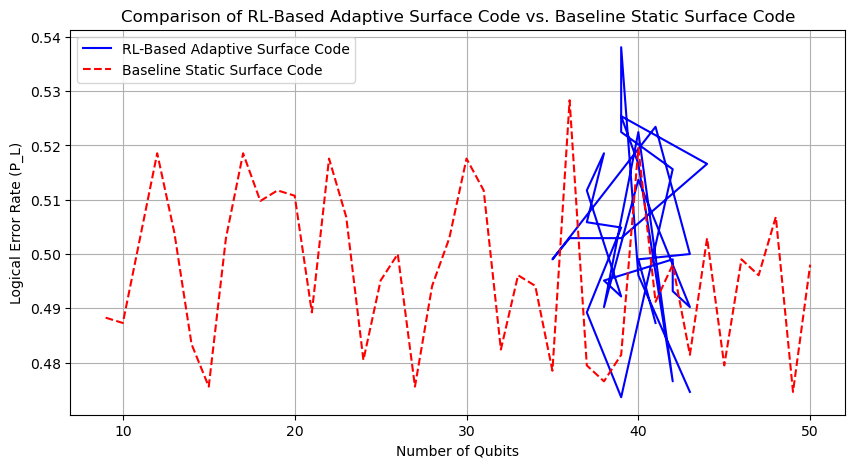

In [186]:
# Now simulate baseline performance (static surface code without RL optimization)
baseline_logical_error_rate_static = []
baseline_qubits_static = list(range(9, MAX_QUBITS+1))

# Simulate logical error rate for a baseline static surface code
for qubits in baseline_qubits_static:
    lattice = SurfaceCodeLattice()
    lattice.qubits = qubits
    P_L = lattice.simulate_logical_error_rate()
    baseline_logical_error_rate_static.append(P_L)

# Plot the comparison
plt.figure(figsize=(10,5))

# RL-based performance
plt.plot(baseline_qubits, baseline_logical_error_rate, label="RL-Based Adaptive Surface Code", color='blue')

# Baseline static surface code performance
plt.plot(baseline_qubits_static, baseline_logical_error_rate_static, label="Baseline Static Surface Code", color='red', linestyle='--')

plt.xlabel("Number of Qubits")
plt.ylabel("Logical Error Rate (P_L)")
plt.title("Comparison of RL-Based Adaptive Surface Code vs. Baseline Static Surface Code")
plt.legend()
plt.grid(True)
plt.show()

print(episodes_reached_target)
print(qubits_added_in_trials)

# Plotting the number of qubits added vs. number of trials
plt.figure(figsize=(10, 6))
plt.plot(episodes_reached_target, qubits_added_in_trials, marker='o', linestyle='-', color='b')
plt.xlabel('Episode Number')
plt.ylabel('Number of Qubits Added')
plt.title('Number of Qubits Added Before Reaching Desired Error Rate')
plt.grid(True)
plt.show()

### Final Output Description

The final output displays the best logical error rate (`P_L`) achieved throughout the reinforcement learning (RL)-driven surface code optimization process. Alongside this, it also prints the number of physical qubits in the surface code layout that led to this optimal error rate.

This result offers a direct summary of the most efficient configuration discovered by the agent — one that minimizes the logical error rate while using as few qubits as possible. It highlights the effectiveness of adaptive code design via RL, offering insight into how many qubits are practically required to achieve a desired level of fault tolerance compared to traditional static approaches.

In [187]:
# Final output
print(f"Best P_L = {best_P_L} at Qubits = {best_lattice.qubits}")

Best P_L = 0.44921875 at Qubits = 38


### Visualizing the Optimal Lattice

After identifying the surface code configuration that achieved the lowest logical error rate (`P_L`), the command `best_lattice.visualize_lattice()` is used to visualize that optimal lattice layout. This visualization provides an intuitive understanding of how the physical qubits are arranged, offering insights into the structural patterns or symmetries that contributed to effective error suppression in the RL-optimized surface code.

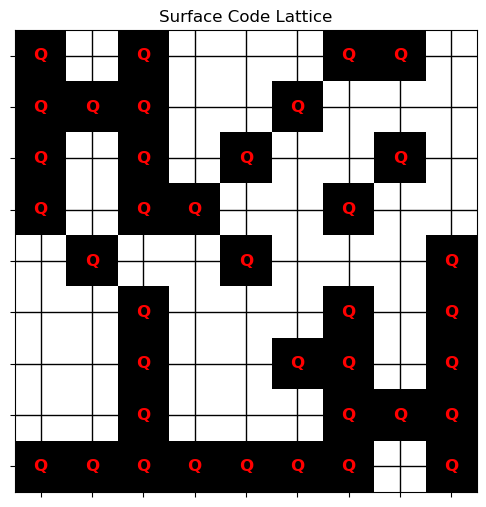

In [188]:
best_lattice.visualize_lattice()